# Hummer-Szabo Projection

This section is based on the finding of
> **Optimal Dimensionality Reduction of Multistate Kinetic and Markov-State Models**  
> Gerhard Hummer and Attila Szabo,  
> *J. Phys. Chem. B* 2015 119 (29), 9029-9037  
> doi: [10.1021/jp508375q](https://pubs.acs.org/doi/10.1021/jp508375q) 


## Theory

Molecular simulations are often used to study the behavior of complex biomolecular systems. These simulations can generate large amounts of data, including information on the conformational states of the system. However, the high dimensionality of the state space can make it difficult to analyze and understand the underlying dynamics of the system.

To address this issue, we often use Markov state models (MSMs) to analyze the dynamics of complex systems. MSMs are constructed by dividing the state space of the system into discrete states and then using the transition probabilities between these states to construct a Markov chain that describes the dynamics of the system. However, using common techniques, the number of microstates can be very large, sometimes in the hundreds. While the dynamics among these microstates may be approximately Markovian, discussing so many states is not feasible. To address this problem, we often lump the microstates into a few so-called macrostates, which can more easily be discussed and analyzed using, e.g., PCCA or MPP.

However, if the timescale separation between the intra- and interstate dynamics is not given, lumping the states can introduce non-Markovian effects, which can materially distort the analysis of the system's dynamics. To overcome this issue, Hummer and Szabo have developed a projection formalism for optimally coarse-graining MSMs, by projecting the microstate dynamics onto the macrostate space. They showed, that this procedure can reduce their dimensionality while preserving the essential dynamical of the microstates. Here, we introduce a simple and fast implementation of the method.


## Implementation in `msmhelper`
Using the Hummer-Szabo projection within the `msmhelper` package is rather easy. Simply create an [`mh.LumpedStateTraj`](../../reference/#msmhelper.LumpedStateTraj) instance via

```Python
traj = mh.LumpedStateTraj(macrotrajs, microtrajs)
```
and use this instead of `mh.StateTraj`. Passing now `traj` to any function within the `msm` module uses the HS projection.

## Impact of Hummer-Szabo Projection

### Model
In the original article, the authors used a 4 state model, where all states are chained up and connected only to their direct neighbors, 
$$
1 \stackrel{k}{\longleftrightarrow} 2 \stackrel{h}{\longleftrightarrow} 3 \stackrel{k}{\longleftrightarrow} 4 
$$
To introduce a second timescales (inner macrostate vs. bourder macrostate) we generalize this model to 8 microstates.
$$
1 \stackrel{k}{\longleftrightarrow} 2 \stackrel{h}{\longleftrightarrow} 3 \stackrel{k}{\longleftrightarrow} 4 \stackrel{h}{\longleftrightarrow} \ldots \stackrel{k}{\longleftrightarrow} 8
$$

Just like the HS Projection, we assume here that we found the optimal lumping by simple lump evry two other to a macrostates, so
$$
\underbrace{(1 \stackrel{k}{\longleftrightarrow} 2)}_{S1} \stackrel{h}{\longleftrightarrow} \underbrace{(3 \stackrel{k}{\longleftrightarrow} 4)}_{S2} \stackrel{h}{\longleftrightarrow} \underbrace{(5 \stackrel{k}{\longleftrightarrow} 6)}_{S3} \stackrel{h}{\longleftrightarrow} \underbrace{(7 \stackrel{k}{\longleftrightarrow} 8)}_{S4}
$$
This means, that we assume that the times scale corresponding to the transition probability $k$ is much faster than the time scale corresponding to $h$.

It should be noted that, the microstate trajectories are sampled from the transition matrix and are therefore perfectly Markovian (up to a statistical, but here neglegtable, error). The only source of non-Markovianty is due to the memory effects of not equilibrating within the macrostate before leaving.

### Create Trajectories
To demonstrate the effect we create 3 sets of trajectories. Starting with $h\gg k$ were we have a optimal lumping, $h=k$ were the lumping is not justified, to $h <k$ were the lumping is poorly choosen.

In [1]:
import msmhelper as mh
import numpy as np
import prettypyplot as pplt
from matplotlib import pyplot as plt
from msmhelper.utils import datasets
from IPython.display import display, display_markdown

pplt.use_style(figsize=(6, 2.5), latex=False, colors='pastel_autunm')

# rate of h, k
rates = ((0.2, 0.05), (0.1, 0.1), (0.1, 0.2))
trajs = {
    rate: {
        label: traj
        for label, traj in zip(
            ('micro', 'macro'),
            datasets.hummer15_8state(*rate, nsteps=int(1e5), return_macrotraj=True),
        )
    }
    for rate in rates
}

### Implied Timescales

We find here that for all three cases, the HS-projection is able to completely reproduce the Markovian microstate dynamics. Even for the first case, were $h = 4*k$, we find that we need a lag time $\tau\approx10$ to converge close to the true time scale.

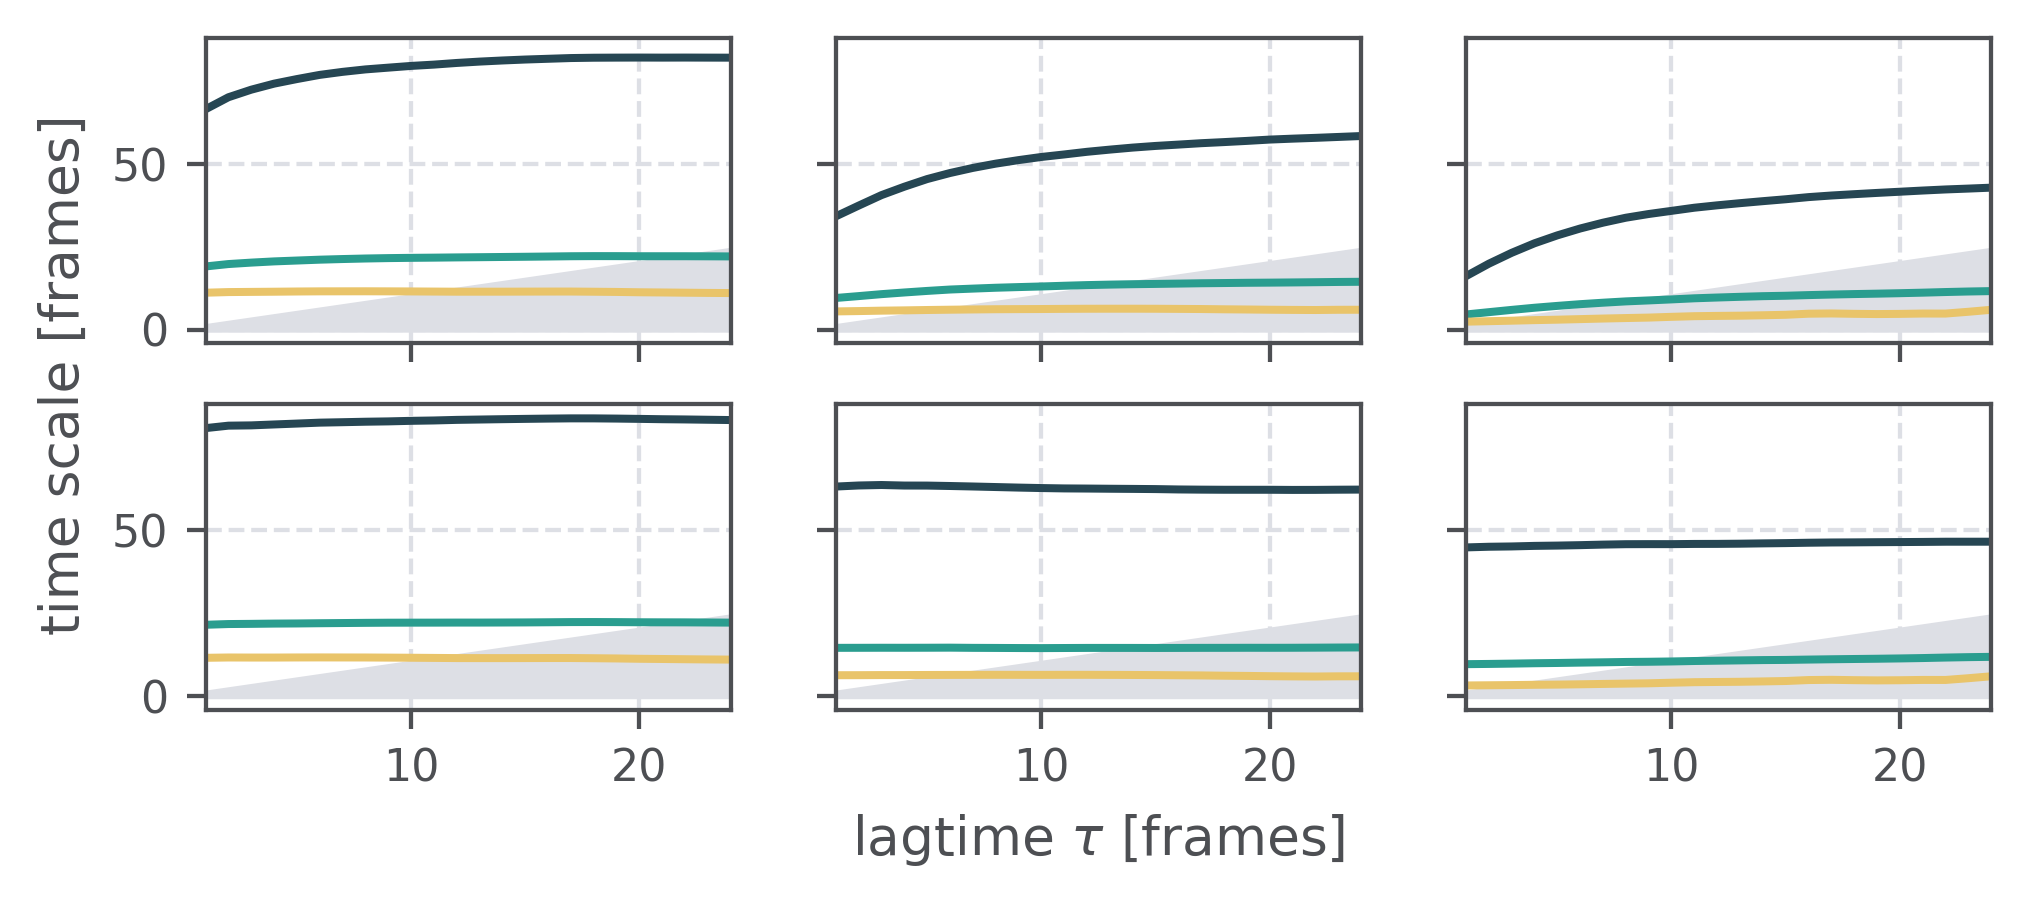

In [2]:
lagtimes = np.arange(1, 25)
_, axs = plt.subplots(2, len(rates), sharey=True, sharex=True)
for idx_rate, (rate, traj) in enumerate(trajs.items()):
    eq_traj = mh.StateTraj(traj['macro'])
    hummer_szabo_traj = mh.LumpedStateTraj(traj['macro'], traj['micro'])
    
    for idx_macro, macrotraj in enumerate((eq_traj, hummer_szabo_traj)):
        ax = axs[idx_macro, idx_rate]
        
        impl_times = mh.msm.implied_timescales(macrotraj, lagtimes, ntimescales=3)
        for idx, impl_time in enumerate(impl_times.T):
            ax.plot(lagtimes, impl_time, label=f'$t_{idx + 1}$')
        
        ax.set_xlim(lagtimes[0], lagtimes[-1])
        # highlight diagonal
        ax.fill_between(ax.get_xlim(), ax.get_xlim(), color='pplt:grid')

pplt.subplot_labels(
    xlabel=r'lagtime $\tau$ [frames]',
    ylabel='time scale [frames]',
)

### Chapman-Kolmogorov Tests

The same picture emerges for the Chapman-Kolmogorov tests. Here we see that HS-projection overestimates slightly the metastability, but besides of that, it is captures for all rate pairs the correct dynamics.

## Rates $h=0.20, k=0.05$

### EQ

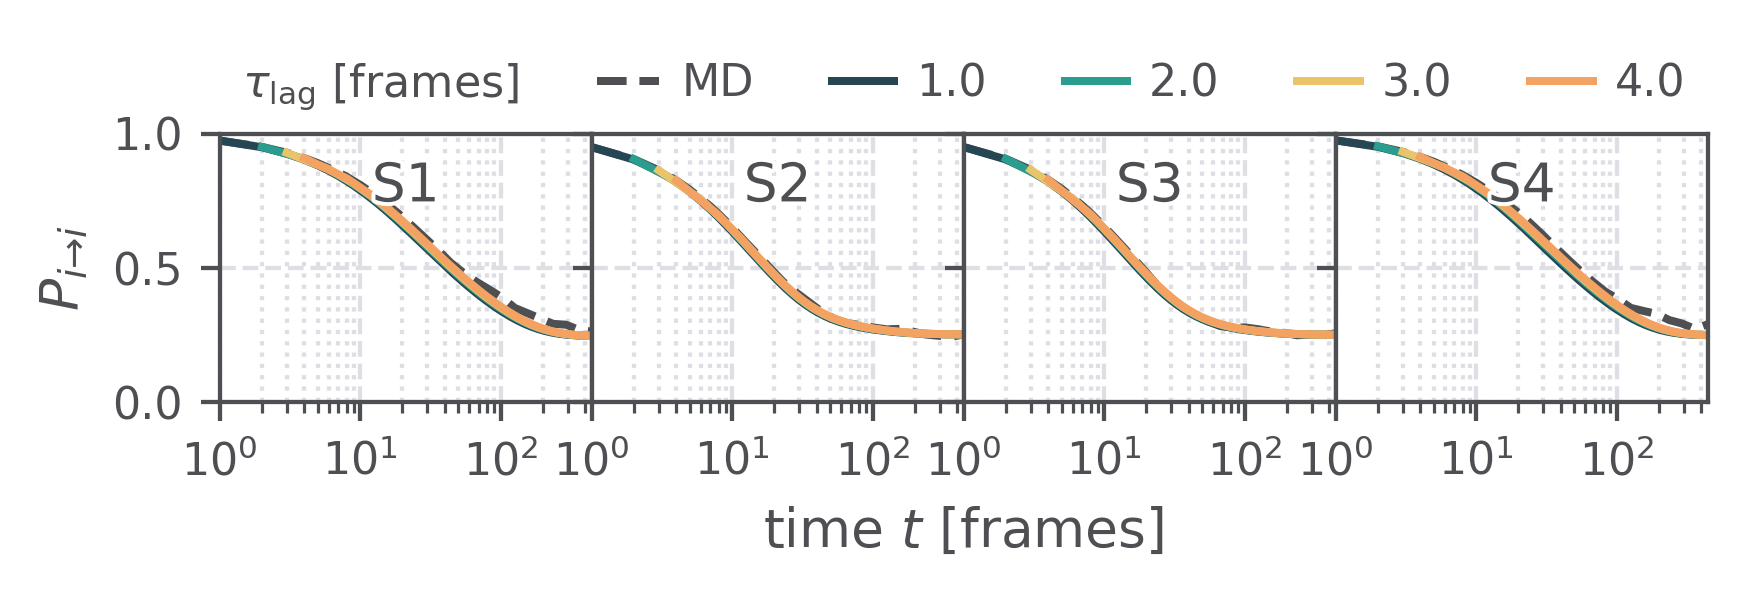

### HS-projection

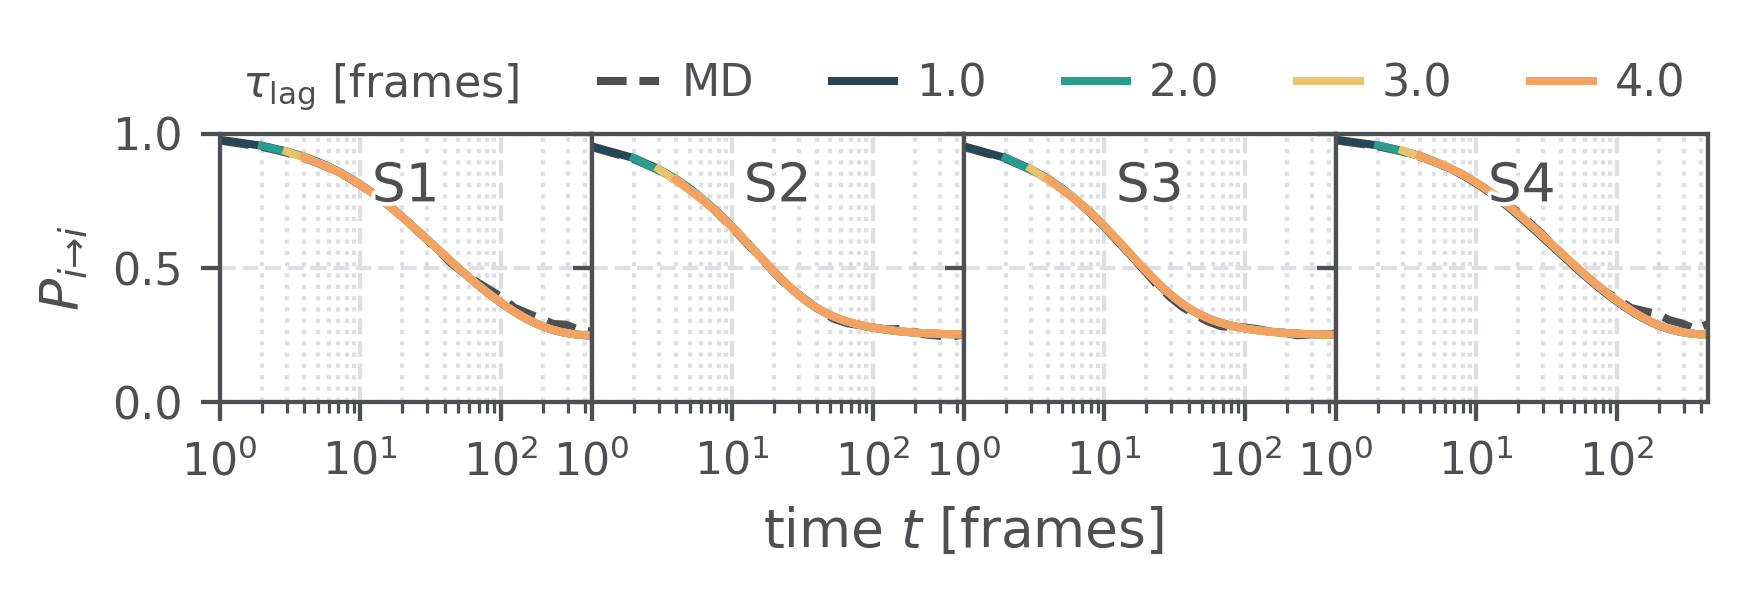

## Rates $h=0.10, k=0.10$

### EQ

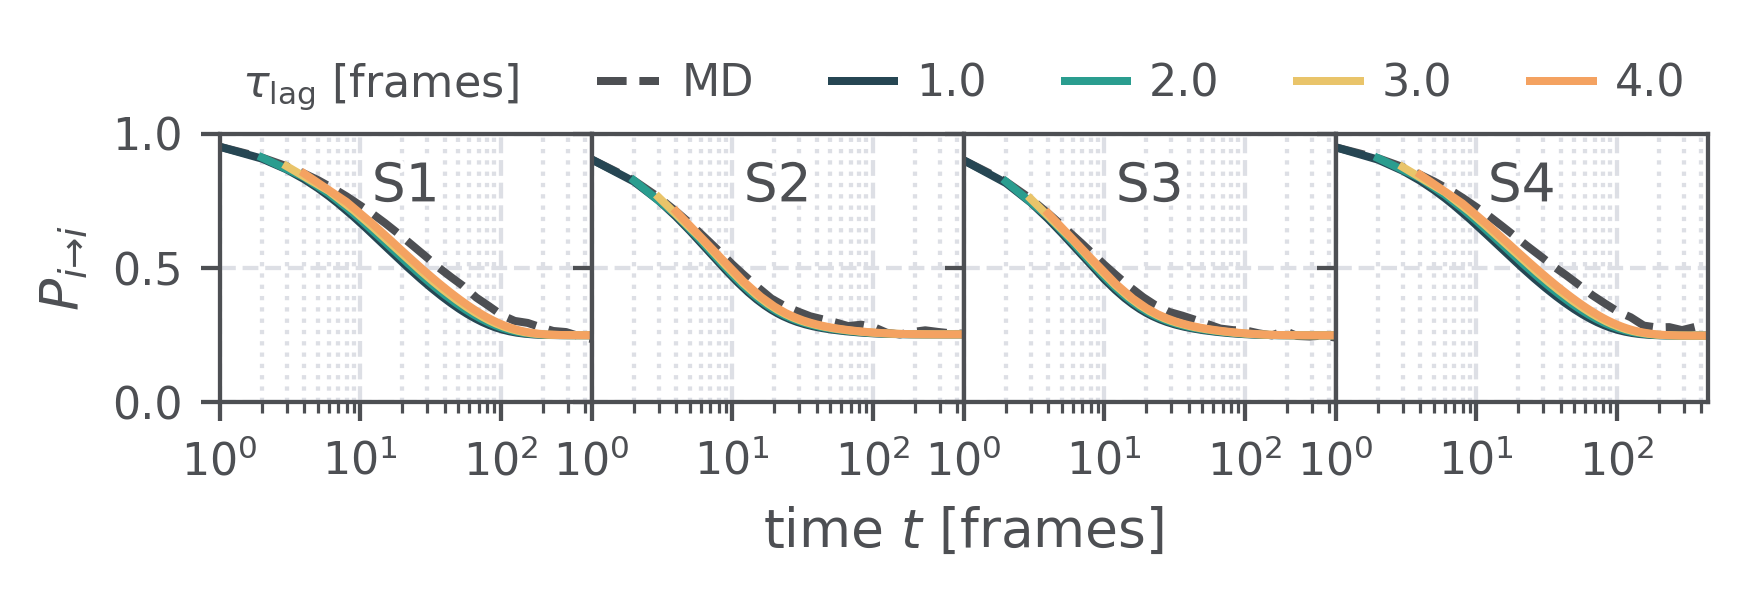

### HS-projection

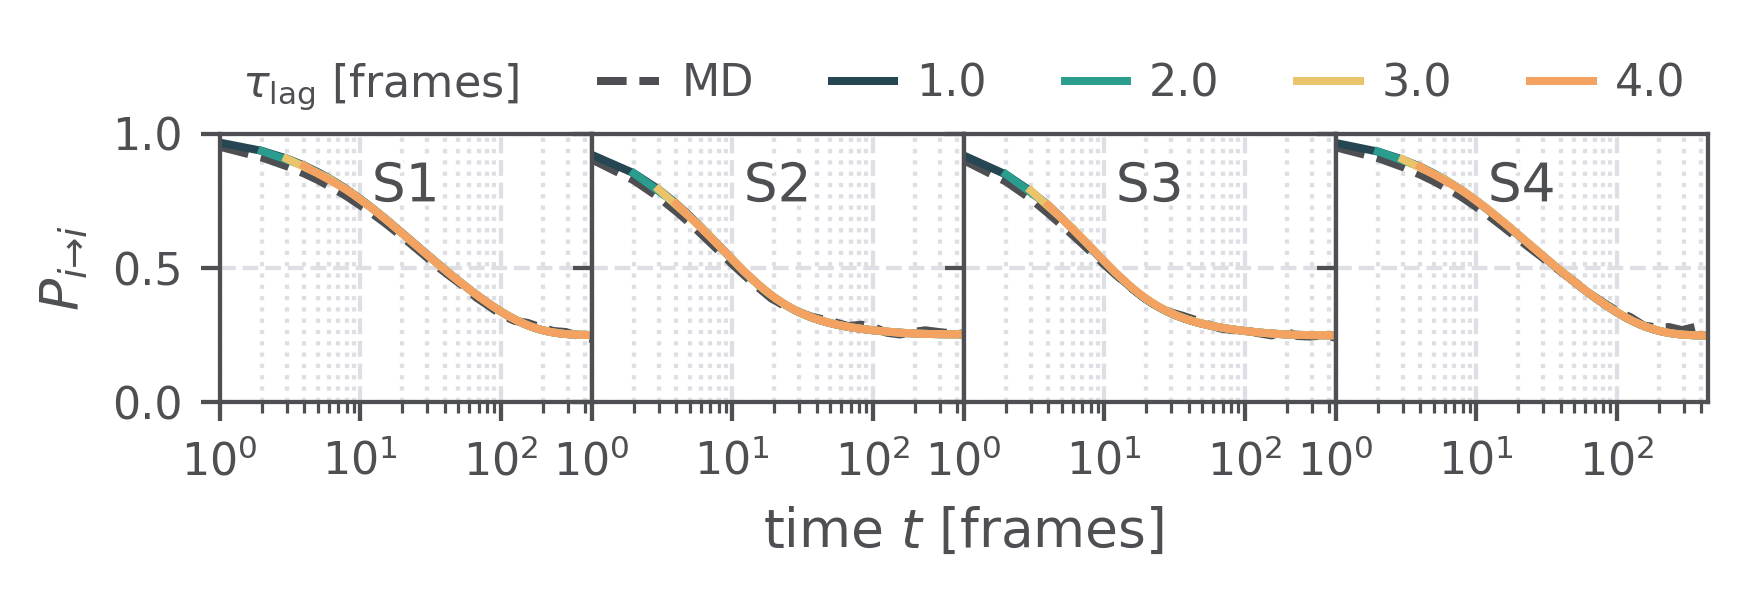

## Rates $h=0.10, k=0.20$

### EQ

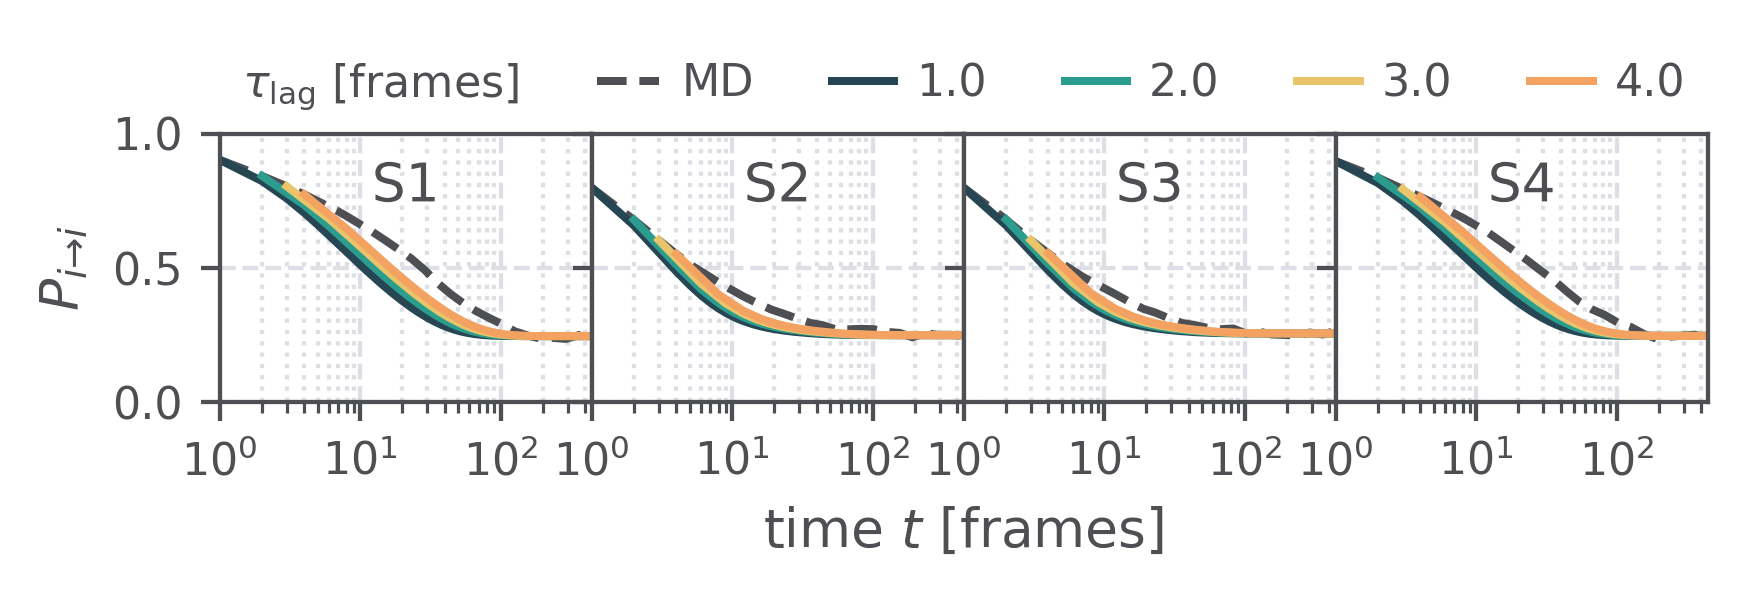

### HS-projection

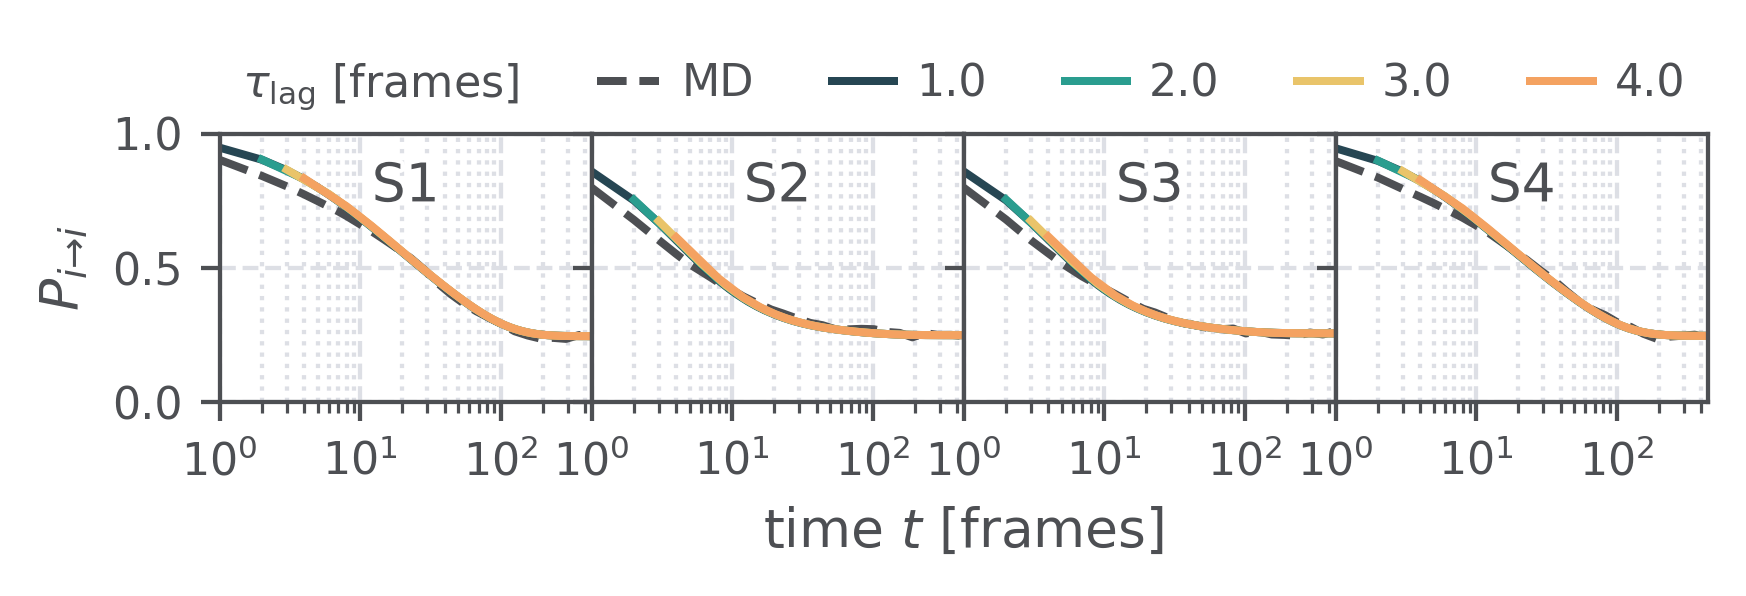

In [3]:
pplt.update_style(figsize=(5, 1.0))
plt.ioff()  # deactivate automatically showing figures
lagtimes = [1, 2, 3, 4]
tmax = 445

for rate, traj in trajs.items():
    display_markdown(fr'## Rates $h={rate[0]:.2f}, k={rate[1]:.2f}$', raw=True)
    
    eq_traj = mh.StateTraj(traj['macro'])
    hummer_szabo_traj = mh.LumpedStateTraj(traj['macro'], traj['micro'])
    
    for label, macrotraj in (
        ('EQ', eq_traj), ('HS-projection', hummer_szabo_traj),
    ):
        ck = mh.msm.ck_test(macrotraj, lagtimes, tmax)
        fig = mh.plot.plot_ck_test(ck=ck, grid=(1, 4))
        display_markdown(fr'### {label}', raw=True)
        display(fig)
        plt.close()